# Regression using a Neural Network (Pytorch)
The data is in 'housing.csv'. <br>
Each row in the table is a data point:  the features of an area in California <br>
Clearly, the `median_house_value` is correlated with some other features, e.g., `median_income` and location <br>
Thus, we can estimate `median_house_value` = regression_model(`median_income`, `longitude`, `latitude`, ...) <br>
The taks is to build an MLP regressor to predict `median_house_value` using the other features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.shape

(20640, 10)

### Data pre-processing: remove NaN

In [4]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
# there are 207 NaN in the column 'total_bedrooms', remove them
# check housing again using housing.isnull().sum()
housing['total_bedrooms'].fillna((housing['total_bedrooms'].mean()), inplace=True)
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Data pre-processing: Convert categorical data to numerical data - "ocean_proximity"

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
#We can use one-hot encoding method by calling pd.get_dummies
categorical_columns=['ocean_proximity'] # must be a list
housing = pd.get_dummies(housing, columns=categorical_columns)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


### Visualize the data

Text(0.5, 1.0, 'median_income')

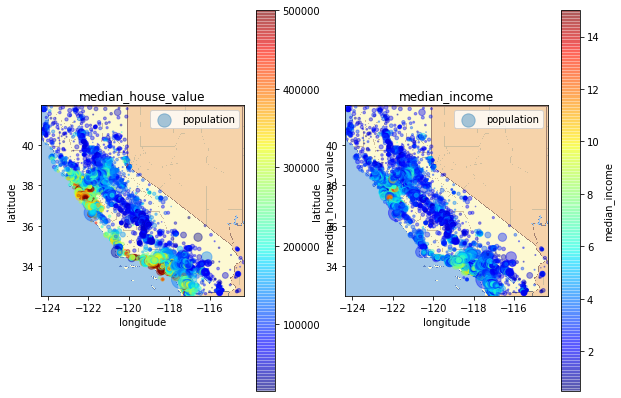

In [8]:
from skimage.io import imread
california_img = imread('california.png')
x1 = min(housing["longitude"].values)
x2 = max(housing["longitude"].values)
y1 = min(housing["latitude"].values)
y2 = max(housing["latitude"].values)
#---------------------------------------------
# the parameter c refers to color
# thus, median_house_value is color-coded in the left plot
fig, ax =plt.subplots(1,2)
housing.plot(ax=ax[0], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
#---------------------------------------------
# the parameter c refers to color
# thus, median_income is color-coded in the right plot
ax[0].imshow(california_img,extent=[x1,x2,y1,y2])
ax[0].set_title('median_house_value')
housing.plot(ax=ax[1], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_income", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
ax[1].imshow(california_img,extent=[x1,x2,y1,y2])
ax[1].set_title('median_income')

### Prepare the Training and Testing Datasets

In [9]:
X=housing.drop(['median_house_value'], axis=1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0


In [10]:
Y=housing['median_house_value']
Y.head()

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64

In [11]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X_columns=X.columns #store the column names
X=X.values.astype('float32')
Y=Y.values.astype('float32')

### trainnig, validation, testing split

In [12]:
#trainnig, validation, testing split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (14860, 13) (14860,)
validation: (1652, 13) (1652,)
test: (4128, 13) (4128,)


In [13]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scalerX=MinMaxScaler()
scalerX.fit(X_train) # think about why fit to X_train, not X ?
X_train=scalerX.transform(X_train)
X_val=scalerX.transform(X_val)
X_test=scalerX.transform(X_test)

In [14]:
X_train[0]

array([0.5786848 , 0.38044596, 0.19607843, 0.12570114, 0.13671634,
       0.00983827, 0.02795593, 0.11055019, 0.        , 1.        ,
       0.        , 0.        , 0.        ], dtype=float32)

In [15]:
#normalize the output to facilitate convergence
Y_train_max=Y_train.max()
Y_train/=Y_train_max
Y_val/=Y_train_max
Y_test/=Y_train_max

### use LinearRegression as the baseline model

In [16]:
#step1:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)

In [17]:
#step2:
linear_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
linear_model.coef_

array([-0.5266741 , -0.4705749 ,  0.11070045, -0.3135651 ,  0.8725228 ,
       -2.8026843 ,  1.0090177 ,  1.1304917 , -0.0472502 , -0.12498075,
        0.26538283, -0.05612995, -0.03702515], dtype=float32)

In [19]:
linear_model.intercept_

0.5496528

Evaluate model on testing set
MSE= 0.018863905
MAE= 0.0993118
MAPE= 0.28951424


Text(0, 0.5, 'Y_test_pred')

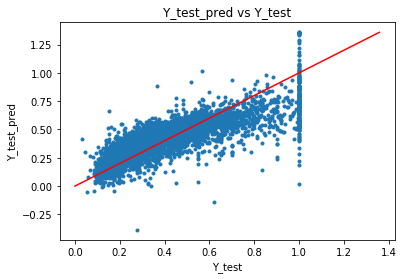

In [20]:
#step3:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
#step6: 
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.set_title('Y_test_pred vs Y_test')
ax.plot(Y_test, Y_test_pred, '.')
ymax=np.max([Y_test.max(), Y_test_pred.max()])
ax.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')

## Your work begins here
see NN_nonlinear_regression_Pytorch.ipynb

#### define a dataset to hold/represent the data

In [22]:
#I give you the code here, because it is tricky
import torch
from torch.utils.data import Dataset as torch_dataset
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y.reshape(-1, 1) #this is very important
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        # use the notation DatasetName[idx]
        # to get a data point (x,y) by idx
        # we need to convert numpy array to torch tensor
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

Create instance objects of the `MyDataset` class <br>
a training dataset `dataset_train` <br>
a validation dataset `dataset_val` <br>
a testing dataset `dataset_test` <br>

In [24]:
len(dataset_train) # get the number of data points in the training set

14860

create dataloaders which will be used to generate minibatches <br>
batch_size=N means each minibatch contains N data points  <br>
note: the last minibatch may contain less than N data points

In [26]:
len(dataloader_train) # get the number of minibatches

117

In [27]:
#verify the shape of each tensor in a batch
for batch_idx, (X, Y) in enumerate(dataloader_train):
    print(batch_idx, X.size(), Y.size())

0 torch.Size([128, 13]) torch.Size([128, 1])
1 torch.Size([128, 13]) torch.Size([128, 1])
2 torch.Size([128, 13]) torch.Size([128, 1])
3 torch.Size([128, 13]) torch.Size([128, 1])
4 torch.Size([128, 13]) torch.Size([128, 1])
5 torch.Size([128, 13]) torch.Size([128, 1])
6 torch.Size([128, 13]) torch.Size([128, 1])
7 torch.Size([128, 13]) torch.Size([128, 1])
8 torch.Size([128, 13]) torch.Size([128, 1])
9 torch.Size([128, 13]) torch.Size([128, 1])
10 torch.Size([128, 13]) torch.Size([128, 1])
11 torch.Size([128, 13]) torch.Size([128, 1])
12 torch.Size([128, 13]) torch.Size([128, 1])
13 torch.Size([128, 13]) torch.Size([128, 1])
14 torch.Size([128, 13]) torch.Size([128, 1])
15 torch.Size([128, 13]) torch.Size([128, 1])
16 torch.Size([128, 13]) torch.Size([128, 1])
17 torch.Size([128, 13]) torch.Size([128, 1])
18 torch.Size([128, 13]) torch.Size([128, 1])
19 torch.Size([128, 13]) torch.Size([128, 1])
20 torch.Size([128, 13]) torch.Size([128, 1])
21 torch.Size([128, 13]) torch.Size([128, 1]

#### Now, let's build a neural network that has many hidden layers and nonlinear activation - softplus

create an instance object of the class

In [30]:
#move the model to GPU if you have a GPU


Net(
  (layer1): Linear(in_features=13, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=1, bias=True)
)

define a function to train the neural network in one epoch

define a function to evaluate the neural network on the validation set or the testing set

create an optimizer (e.g. Adam) and send the parameters of the model to the optimizer

train the neural network model for many epochs <br>
It may need 100 epochs to converge.
So, we will not save any model to harddrive 

Train Epoch: 0 [0/14860 (0%)]	Loss: 0.370886
Train Epoch: 0 [12800/14860 (85%)]	Loss: 0.053270
epoch 0 training loss: 0.05785210914591439
epoch 0 validation loss: 0.04418320502842309
Train Epoch: 1 [0/14860 (0%)]	Loss: 0.055375
Train Epoch: 1 [12800/14860 (85%)]	Loss: 0.037720
epoch 1 training loss: 0.03833816999680976
epoch 1 validation loss: 0.03461824822945399
Train Epoch: 2 [0/14860 (0%)]	Loss: 0.041361
Train Epoch: 2 [12800/14860 (85%)]	Loss: 0.024778
epoch 2 training loss: 0.030524458847621568
epoch 2 validation loss: 0.027721758471851488
Train Epoch: 3 [0/14860 (0%)]	Loss: 0.023379
Train Epoch: 3 [12800/14860 (85%)]	Loss: 0.020735
epoch 3 training loss: 0.024682435342389293
epoch 3 validation loss: 0.0235659202998256
Train Epoch: 4 [0/14860 (0%)]	Loss: 0.019794
Train Epoch: 4 [12800/14860 (85%)]	Loss: 0.027153
epoch 4 training loss: 0.022244470870583996
epoch 4 validation loss: 0.02353142479718742
Train Epoch: 5 [0/14860 (0%)]	Loss: 0.022251
Train Epoch: 5 [12800/14860 (85%)]	Lo

Train Epoch: 44 [12800/14860 (85%)]	Loss: 0.018449
epoch 44 training loss: 0.017611946027057294
epoch 44 validation loss: 0.01891214672936077
Train Epoch: 45 [0/14860 (0%)]	Loss: 0.017326
Train Epoch: 45 [12800/14860 (85%)]	Loss: 0.020810
epoch 45 training loss: 0.017250327345652457
epoch 45 validation loss: 0.01886421341007039
Train Epoch: 46 [0/14860 (0%)]	Loss: 0.019603
Train Epoch: 46 [12800/14860 (85%)]	Loss: 0.015955
epoch 46 training loss: 0.017682841389925562
epoch 46 validation loss: 0.018850531618473894
Train Epoch: 47 [0/14860 (0%)]	Loss: 0.018259
Train Epoch: 47 [12800/14860 (85%)]	Loss: 0.015349
epoch 47 training loss: 0.017499074276186462
epoch 47 validation loss: 0.019245577637854845
Train Epoch: 48 [0/14860 (0%)]	Loss: 0.019481
Train Epoch: 48 [12800/14860 (85%)]	Loss: 0.020968
epoch 48 training loss: 0.017712520443412483
epoch 48 validation loss: 0.018788406187916495
Train Epoch: 49 [0/14860 (0%)]	Loss: 0.017374
Train Epoch: 49 [12800/14860 (85%)]	Loss: 0.019014
epoch 

Train Epoch: 88 [12800/14860 (85%)]	Loss: 0.016520
epoch 88 training loss: 0.016713629548366252
epoch 88 validation loss: 0.01869327674189145
Train Epoch: 89 [0/14860 (0%)]	Loss: 0.018834
Train Epoch: 89 [12800/14860 (85%)]	Loss: 0.013128
epoch 89 training loss: 0.0166006408767122
epoch 89 validation loss: 0.018880145529569205
Train Epoch: 90 [0/14860 (0%)]	Loss: 0.016568
Train Epoch: 90 [12800/14860 (85%)]	Loss: 0.018479
epoch 90 training loss: 0.016605845748040922
epoch 90 validation loss: 0.01806729967022635
Train Epoch: 91 [0/14860 (0%)]	Loss: 0.012652
Train Epoch: 91 [12800/14860 (85%)]	Loss: 0.018578
epoch 91 training loss: 0.016640313972647373
epoch 91 validation loss: 0.019471545052008824
Train Epoch: 92 [0/14860 (0%)]	Loss: 0.010140
Train Epoch: 92 [12800/14860 (85%)]	Loss: 0.021039
epoch 92 training loss: 0.016624445278738808
epoch 92 validation loss: 0.018402158348092734
Train Epoch: 93 [0/14860 (0%)]	Loss: 0.014515
Train Epoch: 93 [12800/14860 (85%)]	Loss: 0.018634
epoch 93

plot the loss vs epoch curve

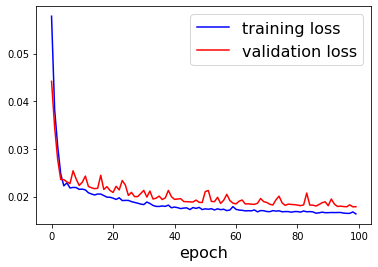

In [37]:
# obtain Yp_test
# "Yp_test=model(X_test)"  may need lots of memory
# we can use a for loop to get Yp_test, see the function test
Yp_test=[]
with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
    for batch_idx, (X, Y) in enumerate(dataloader_test):
        X, Y = X.to(device), Y.to(device)
        Yp = model(X)#forward pass
        Yp_test.append(Yp.detach().cpu().numpy())
Yp_test=np.concatenate(Yp_test, axis=0).squeeze()

In [47]:
# compute MSE, MAE and MAPE on testing set


Evaluate model on testing set
MSE= 0.01647303
MAE= 0.0901616
MAPE= 0.2513569


Text(0, 0.5, 'Yp_test')

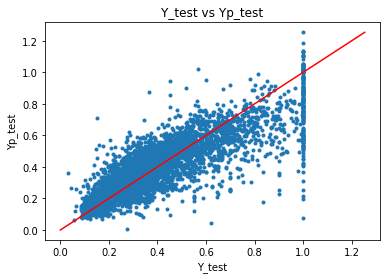

In [53]:
# plot Yp_test vs Y_test
# the red line is the 45-degree line


### change the structure of the MLP model and see if it can do better than XGBoost in homework 2
You will get 5 extra points if the model does better than xgboost regressor (measured by MAPE) <br>
You will lose 5 points if you do not try <br>
If you have done this sub-task in H3P2T2_Keras_solution.ipynb, then do not waste your time here (no extra points)